In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

## Pre-processing

In [2]:
df = pd.read_csv('autos.csv', encoding='ISO-8859-1')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.shape

(371528, 20)

In [4]:
# removing dates and dropping duplicate entries
df = df.drop(labels = ['dateCrawled', 'dateCreated', 'lastSeen'], axis = 1)
df = df.drop_duplicates()
df.shape

(367148, 17)

In [5]:
# removing the rest of unnecessary labels
df = df.drop(labels = ['name', 'powerPS', 'offerType' ,'abtest', 'model', 'monthOfRegistration', 'nrOfPictures', 'postalCode'], axis = 1)
df.columns

Index(['seller', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [6]:
df.isnull().sum()

seller                    0
price                     0
vehicleType           37613
yearOfRegistration        0
gearbox               19946
kilometer                 0
fuelType              33208
brand                     0
notRepairedDamage     71256
dtype: int64

### Removing scammy listings
Some listings may have prices that are way too high or way too low; some suspicious listing put in kilometerage (mileage) that is unreasonably high or low. Also, the registration (production year) of the car may be listed as a year before cars were even manufactured, or as a year in future. I am going to remove those listings because they are untrustworthy and don't represent the actual price dynamics. 
#### Checking the prices

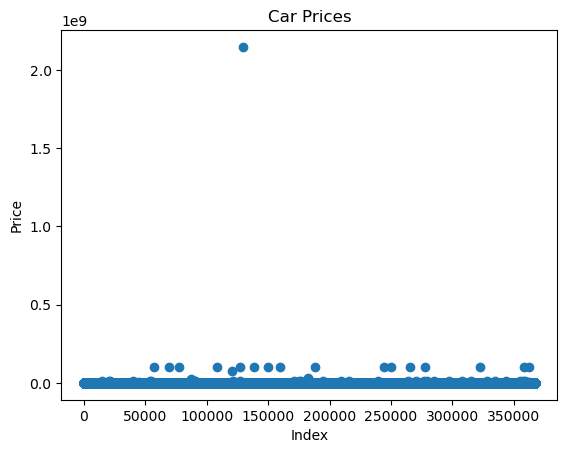

In [7]:
plt.scatter(range(len(df)), df['price'])
plt.title('Car Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

Assuming that used cars will cost under 100,000 euros

In [8]:
# only leaving listings with the price less than 100,000
df = df[df['price'] < 100000]

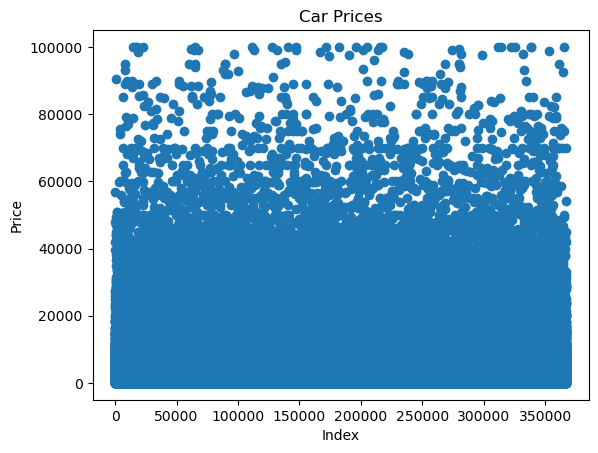

In [9]:
plt.scatter(range(len(df)), df['price'])
plt.title('Car Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

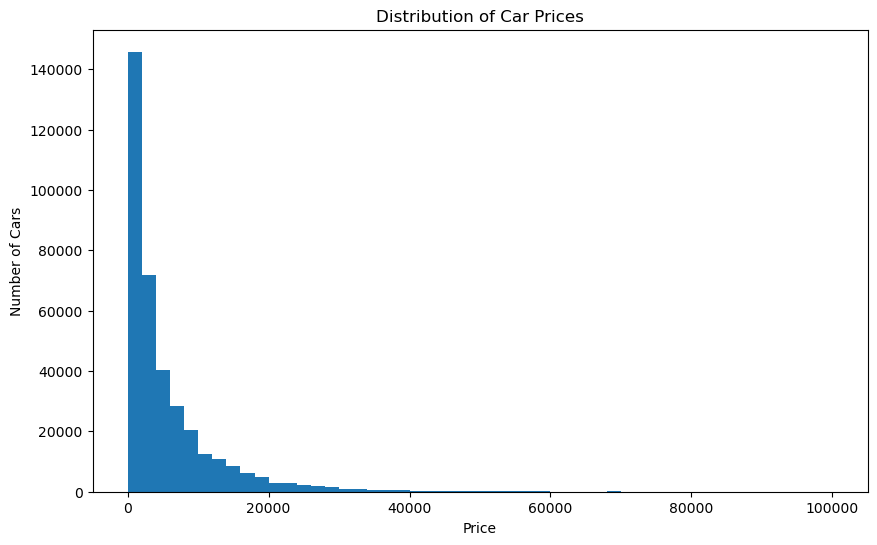

In [10]:
df['price'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')
plt.show()

In [11]:
# only leaving listings with the price greater than 300 euros and less than 30,000 euros
df = df[(df['price'] > 300) & (df['price'] < 30000)]
df.shape

(335571, 9)

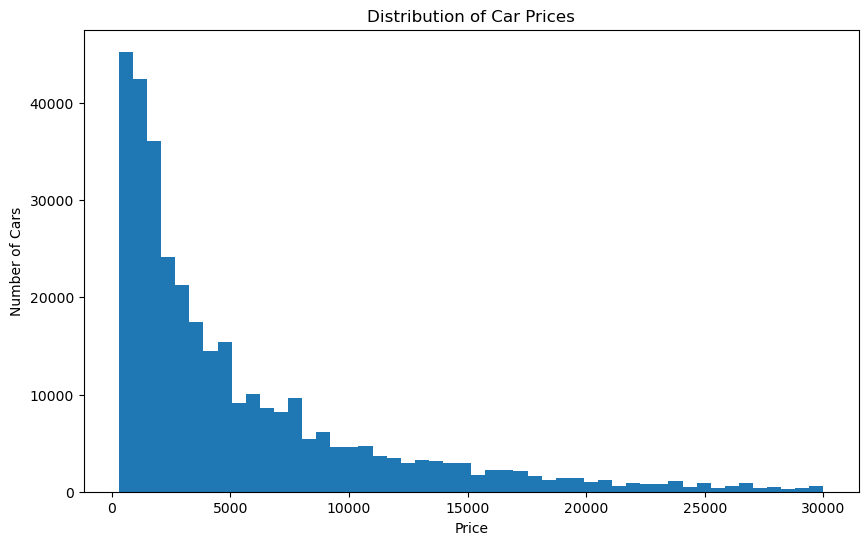

In [12]:
df['price'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')
plt.show()

Now the price distribution looks more realistic

#### Checking the kilometerage

In [13]:
df['kilometer'].value_counts().sort_index()

kilometer
5000        4414
10000       1395
20000       4511
30000       5092
40000       5614
50000       6906
60000       7937
70000       9035
80000      10251
90000      11618
100000     14466
125000     35542
150000    218790
Name: count, dtype: int64

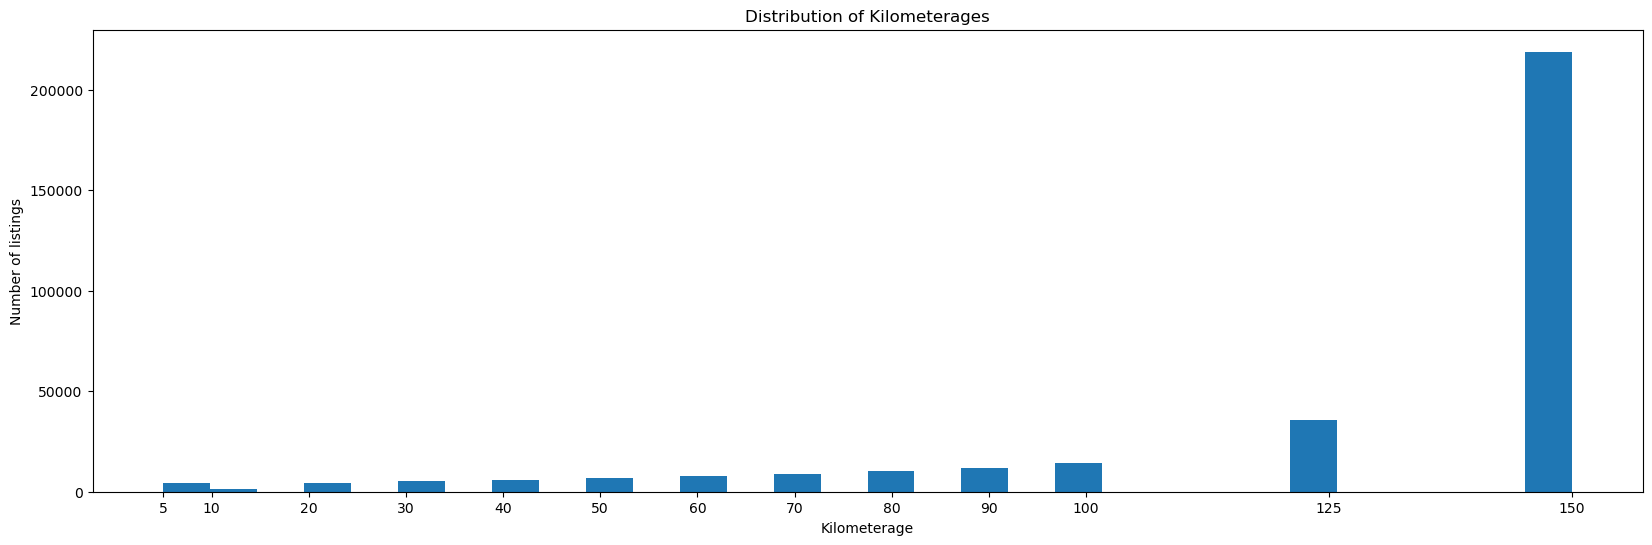

In [14]:
plt.figure(figsize=(20, 6))
plt.hist(df['kilometer'], bins=30)
plt.title('Distribution of Kilometerages')
plt.xlabel('Kilometerage')
plt.ylabel('Number of listings')
ticks = [5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]
tick_labels = [str(int(tick/1000)) for tick in ticks]
plt.xticks(ticks, tick_labels)
plt.show()

We can see that there are more listings with 5000 kilometers (3.1k miles) than with 10000 kilometers, which is suspicious. Therefore, I will drop all listings for cars older than 3 years that list that they only have 5000 kilometers.

In [15]:
df.drop(df[(df['kilometer'] == 5000) & (df['yearOfRegistration'] < 2013)].index, inplace=True)
df.shape

(332342, 9)

Similarly, there seems to be too many cars with 150,000 kilometers (93.2k miles). I will drop all cars with 150,000 kilometers that are 3 years old or newer.

In [16]:
df.drop(df[(df['kilometer'] == 150000) & (df['yearOfRegistration'] >= 2013)].index, inplace=True)
df.shape

(316342, 9)

### Checking the date range

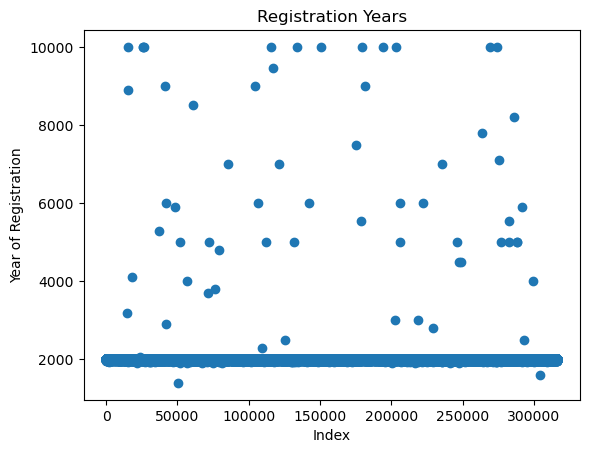

In [17]:
plt.scatter(range(len(df)), df['yearOfRegistration'])
plt.title('Registration Years')
plt.xlabel('Index')
plt.ylabel('Year of Registration')
plt.show()

In [18]:
df['yearOfRegistration'].min()

1400

#### Estimating the valid date range

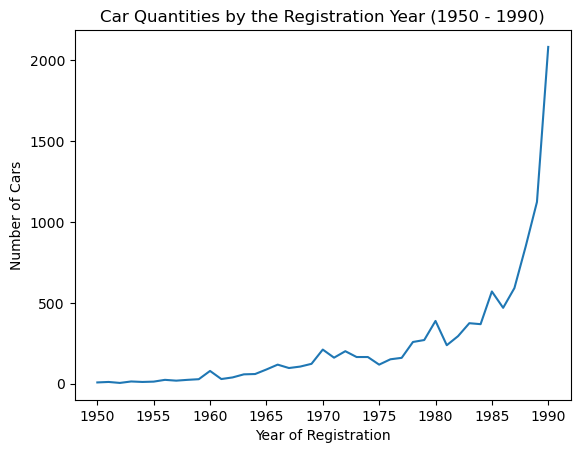

In [19]:
# estimating the earliest reasonable date
newdf = df[(df['yearOfRegistration'] >= 1950) & (df['yearOfRegistration']<=1990)]
values = (newdf['yearOfRegistration'].value_counts().sort_index())
values.plot()
plt.title('Car Quantities by the Registration Year (1950 - 1990)')
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.show()

According to this graph, the earliest reasonable date seems to be in late 1950s. Therefore, I will assume the valid year range to be 1956 - 2016 (the dataset was created in 2016).

#### Removing the listings that have the year of registration before 1956 and after 2016


In [20]:
df = df[(df['yearOfRegistration'] >= 1956)&(df['yearOfRegistration']<=2016)]
df.shape

(312541, 9)

### Translating entries from German

In [21]:
df['seller'].unique()

array(['privat', 'gewerblich'], dtype=object)

In [22]:
df['seller'].replace('privat','private',inplace = True)
df['seller'].replace('gewerblich','commercial',inplace = True)

In [23]:
df['vehicleType'].unique()

array([nan, 'coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus',
       'kombi', 'andere'], dtype=object)

In [24]:
df['vehicleType'].replace(np.nan,'type_unspecified',inplace=True)
df['vehicleType'].replace('kleinwagen','subcompact',inplace = True)
df['vehicleType'].replace('bus','minivan',inplace = True)
df['vehicleType'].replace('kombi','hatchback',inplace = True)
df['vehicleType'].replace('andere','other',inplace = True)

In [25]:
df['gearbox'].unique()

array(['manuell', 'automatik', nan], dtype=object)

In [26]:
df['gearbox'].replace(np.nan,'gear_unspecified',inplace=True)
df['gearbox'].replace('manuell','manual',inplace = True)
df['gearbox'].replace('automatik','automatic',inplace = True)

In [27]:
df['fuelType'].unique()

array(['benzin', 'diesel', nan, 'lpg', 'andere', 'hybrid', 'cng',
       'elektro'], dtype=object)

In [28]:
df['fuelType'].replace(np.nan,'fuel_unspecified',inplace=True)
df['fuelType'].replace('benzin','gasoline',inplace = True)
df['fuelType'].replace('andere','other',inplace = True)
df['fuelType'].replace('elektro','electric',inplace = True)

In [29]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'suzuki', 'lancia', 'porsche',
       'citroen', 'toyota', 'kia', 'chevrolet', 'dacia', 'sonstige_autos',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

In [30]:
df['notRepairedDamage'].unique()

array([nan, 'ja', 'nein'], dtype=object)

In [31]:
df['notRepairedDamage'].replace(np.nan,'damage_unspecified',inplace=True)
df['notRepairedDamage'].replace('ja','yes',inplace = True)
df['notRepairedDamage'].replace('nein','no',inplace = True)

In [32]:
df.isnull().sum()

seller                0
price                 0
vehicleType           0
yearOfRegistration    0
gearbox               0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
dtype: int64

In [33]:
df.head()

,seller,price,vehicleType,yearOfRegistration,gearbox,kilometer,fuelType,brand,notRepairedDamage
0,private,480,type_unspecified,1993,manual,150000,gasoline,volkswagen,damage_unspecified
1,private,18300,coupe,2011,manual,125000,diesel,audi,yes
2,private,9800,suv,2004,automatic,125000,diesel,jeep,damage_unspecified
3,private,1500,subcompact,2001,manual,150000,gasoline,volkswagen,no
4,private,3600,subcompact,2008,manual,90000,diesel,skoda,no


### Replacing categorical values with dummies

In [34]:
seller = pd.get_dummies(df['seller'])
v_type = pd.get_dummies(df['vehicleType'])
gearbox = pd.get_dummies(df['gearbox'])
fuel = pd.get_dummies(df['fuelType'])
brand = pd.get_dummies(df['brand'])
damage = pd.get_dummies(df['notRepairedDamage'])
df = pd.concat([df, seller, v_type, gearbox, fuel, brand, damage], axis = 1)
df = df.drop(labels = ['seller', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage' ], axis = 1)

In [35]:
df.head()

,price,yearOfRegistration,kilometer,commercial,private,cabrio,coupe,hatchback,limousine,minivan,...,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,damage_unspecified,no,yes
0,480,1993,150000,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,18300,2011,125000,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,9800,2004,125000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1500,2001,150000,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
4,3600,2008,90000,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Checking the average listing price in the dataset, for future references

In [36]:
df['price'].mean()

5541.068659791836

## Processing

### Splitting the dataset

In [37]:
# randomly shuffling the dataset
df = df.sample(frac=1).reset_index(drop=True)
# splitting the features and the labels
X = df.drop('price', axis=1)
y = df['price']

# splitting the dataset into test(20%), validation(15%) and training(65%)
test_size = int(0.20 * len(df))
val_size = int(0.15 * len(df))
train_size = len(df) - val_size - test_size

# first 20% goes to testing
X_test = X[:test_size]
y_test = y[:test_size]

# next 15% - to validation
X_val = X[test_size:test_size + val_size]
y_val = y[test_size:test_size + val_size]

# the rest goes to training
X_train = X[test_size + val_size:]
y_train = y[test_size + val_size:]

### Scaling

In [38]:
# changing zeroes to ones to avoid division by zero and not scaling those zero-value features
def zero_removal(st_dev_):
    new_st_dev = []
    for val_ in st_dev_:
        if val_ == 0:
            new_st_dev.append(1)
        else:
            new_st_dev.append(val_)
    return np.array(new_st_dev)


# implementing the standard scaler
def scale(X, mean_val_, st_dev_):
    X_scaled = (X - mean_val_) / st_dev_
    return X_scaled

# computing mean and standard deviation from the train subset
mean_val = np.mean(X_train, axis=0)
st_dev = np.std(X_train, axis=0)
# replacing zeroes
st_dev = zero_removal(st_dev)

# scaling the train, validation and test subsets
X_train_scaled = scale(X_train, mean_val, st_dev)
X_val_scaled = scale(X_val, mean_val, st_dev)
X_test_scaled = scale(X_test, mean_val, st_dev)

### Getting performance estimates

In [39]:
def get_estimates(y_, y_pred_):
    # computing RMSE, rounded to a whole number
    rmse = int(round(np.sqrt(np.mean((y_ - y_pred_) ** 2)),0))
    
    # computing MAE, rounded to a whole number
    mae = int(round(np.mean(np.abs(y_ - y_pred_)),0))

    # computing MedAE, rounded to a whole number
    medae = int(round(np.median(np.abs(y_ - y_pred_)),0))

    # computing R^2, rounded to two decimals
    ss_res = np.sum((y_ - y_pred_) ** 2)
    ss_tot = np.sum((y_ - np.mean(y_)) ** 2)
    r2 = round(1 - (ss_res / ss_tot), 2)
    
    print(f'Root Mean Squared Error (RMSE): {rmse:>2}'
          f'\nMean Absolute Error (MAE): {mae:>9}'
          f'\nMedian Absolute Error (MedAE): {medae:>5}'
          f'\nR^2 Score: {r2:>25}')

### Choosing a model

#### Trying basic off-the-shelf Least Squares Regression

In [40]:
# adding a stack of ones to both training and validation set for OLS to work
X_train_scaled_sm = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_val_scaled_sm = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])

model1 = sm.OLS(y_train, X_train_scaled_sm).fit()
y_val_pred1 = model1.predict(X_val_scaled_sm)

get_estimates(y_val, y_val_pred1)

Root Mean Squared Error (RMSE): 3600
Mean Absolute Error (MAE):      2480
Median Absolute Error (MedAE):  1750
R^2 Score:                      0.61


#### Trying basic off-the-shelf Lasso Regression

In [41]:
model2 = Lasso(max_iter=10000)
model2.fit(X_train_scaled, y_train)

y_val_pred2 = model2.predict(X_val_scaled)

get_estimates(y_val, y_val_pred2)

Root Mean Squared Error (RMSE): 3600
Mean Absolute Error (MAE):      2480
Median Absolute Error (MedAE):  1748
R^2 Score:                      0.61


Both OLS and Lasso models showed suboptimal results, so I decided to implement a different model.

#### Trying basic off-the-shelf Decision Tree Regressor

In [42]:
model3 = DecisionTreeRegressor()
model3.fit(X_train, y_train)

y_val_pred3 = model3.predict(X_val)

get_estimates(y_val, y_val_pred3)

Root Mean Squared Error (RMSE): 2730
Mean Absolute Error (MAE):      1535
Median Absolute Error (MedAE):   771
R^2 Score:                      0.77


The Decision Tree Regressor showed a much better result, so this is the model I am going to implement.

### Feature Implementation Techniques

#### Principal Component Analysis

In [43]:
# applying PCA to all subsets
def apply_pca(n_, X_train_, X_val_, X_test_):
    pca = PCA(n_components=n_)
    X_train_pca_ = pca.fit_transform(X_train_)
    X_val_pca_ = pca.transform(X_val_)
    X_test_pca_ = pca.transform(X_test_)
    return X_train_pca_, X_val_pca_, X_test_pca_

#### Finding the optimal number of components for PCA

In [44]:
rmses = []
maes = []
medaes = []
r2s = []
comp_range = range(2, 68)
for n in comp_range:
    # applying PCA
    X_train_pca, X_val_pca, X_test_pca = apply_pca(n, X_train, X_val, X_test)

    model4 = DecisionTreeRegressor()
    model4.fit(X_train_pca, y_train)
    y_val_pred4 = model4.predict(X_val_pca)
    
    # computing RMSE, rounded to a whole number
    rmse = int(round(np.sqrt(np.mean((y_val - y_val_pred4) ** 2)),0))
    rmses.append(rmse)
    
    # computing MAE, rounded to a whole number
    mae = int(round(np.mean(np.abs(y_val - y_val_pred4)),0))
    maes.append(mae)

    # computing MedAE, rounded to a whole number
    medae = int(round(np.median(np.abs(y_val - y_val_pred4)),0))
    medaes.append(medae)

    # computing R^2, rounded to two decimals
    ss_res = np.sum((y_val - y_val_pred4) ** 2)
    ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
    r2 = round(1 - (ss_res / ss_tot), 2)
    r2s.append(r2)

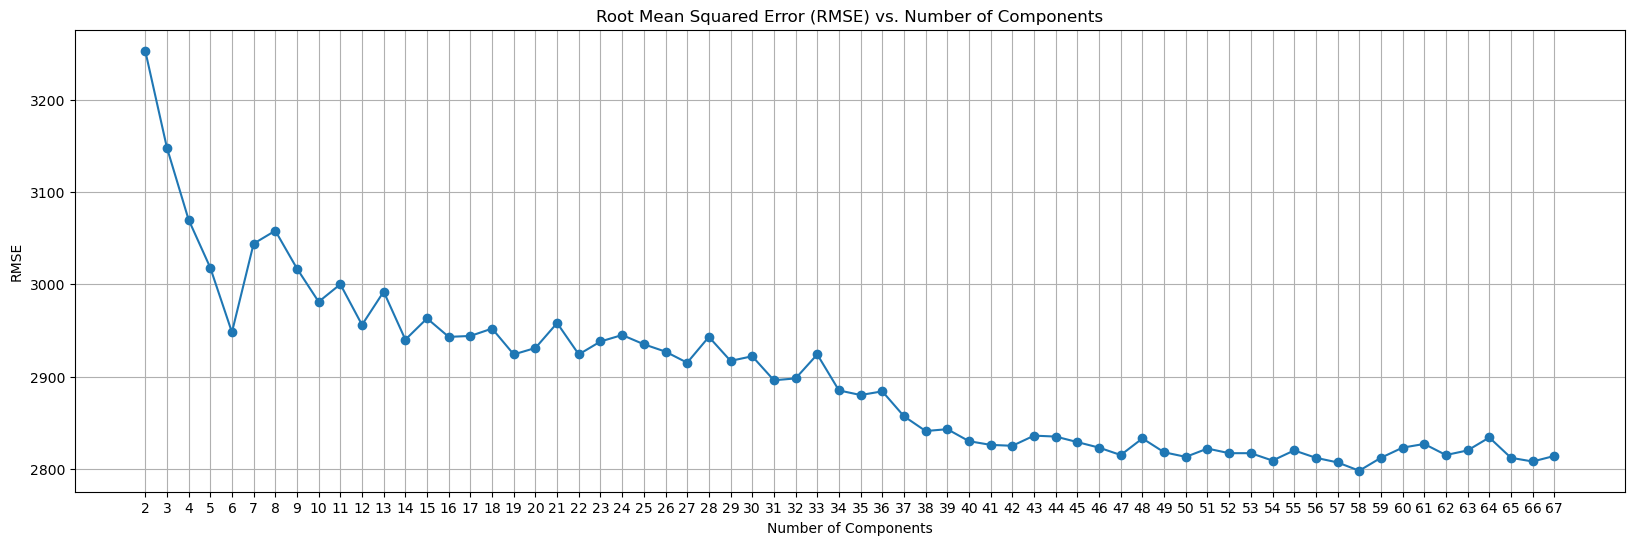

In [45]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, rmses, marker='o')
plt.title('Root Mean Squared Error (RMSE) vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

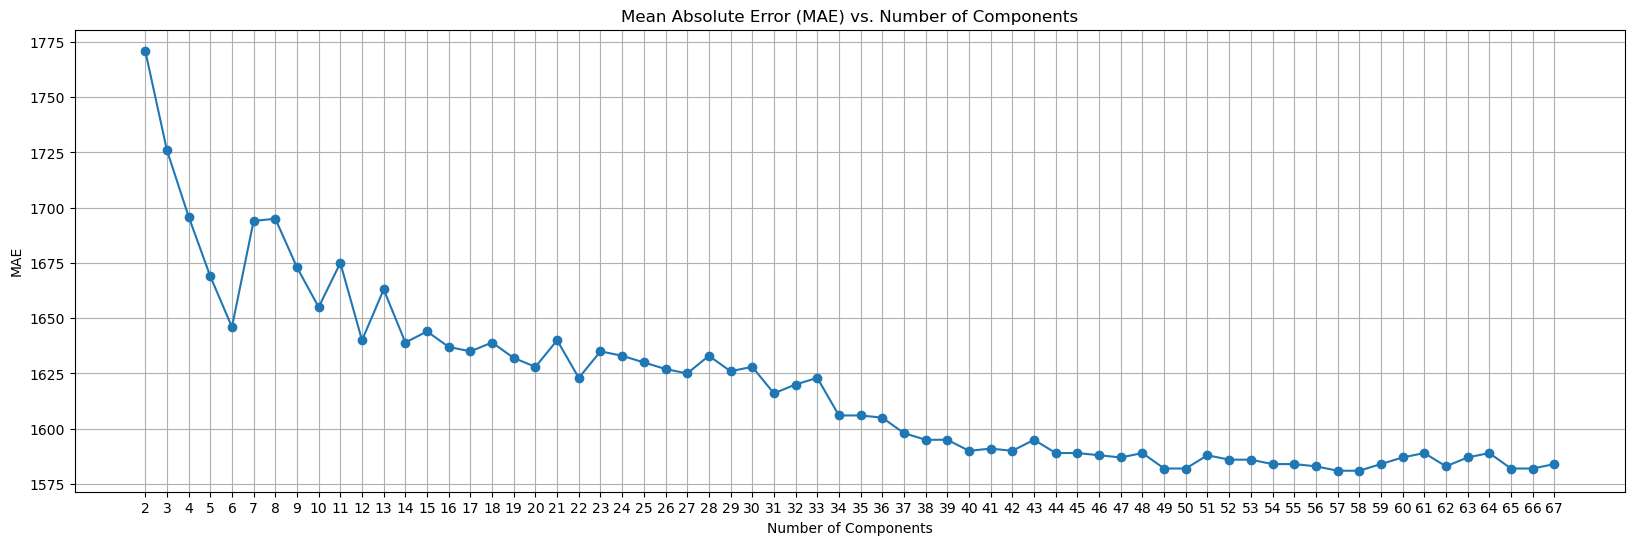

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, maes, marker='o')
plt.title('Mean Absolute Error (MAE) vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MAE')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

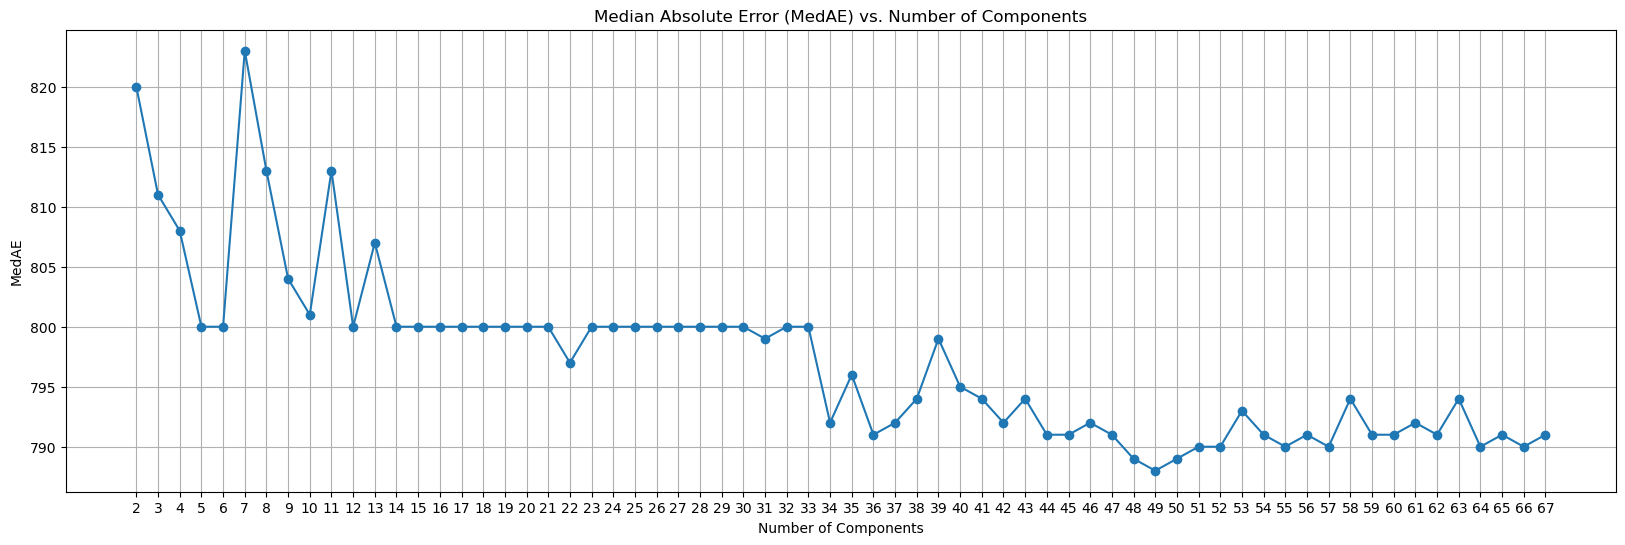

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, medaes, marker='o')
plt.title('Median Absolute Error (MedAE) vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MedAE')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

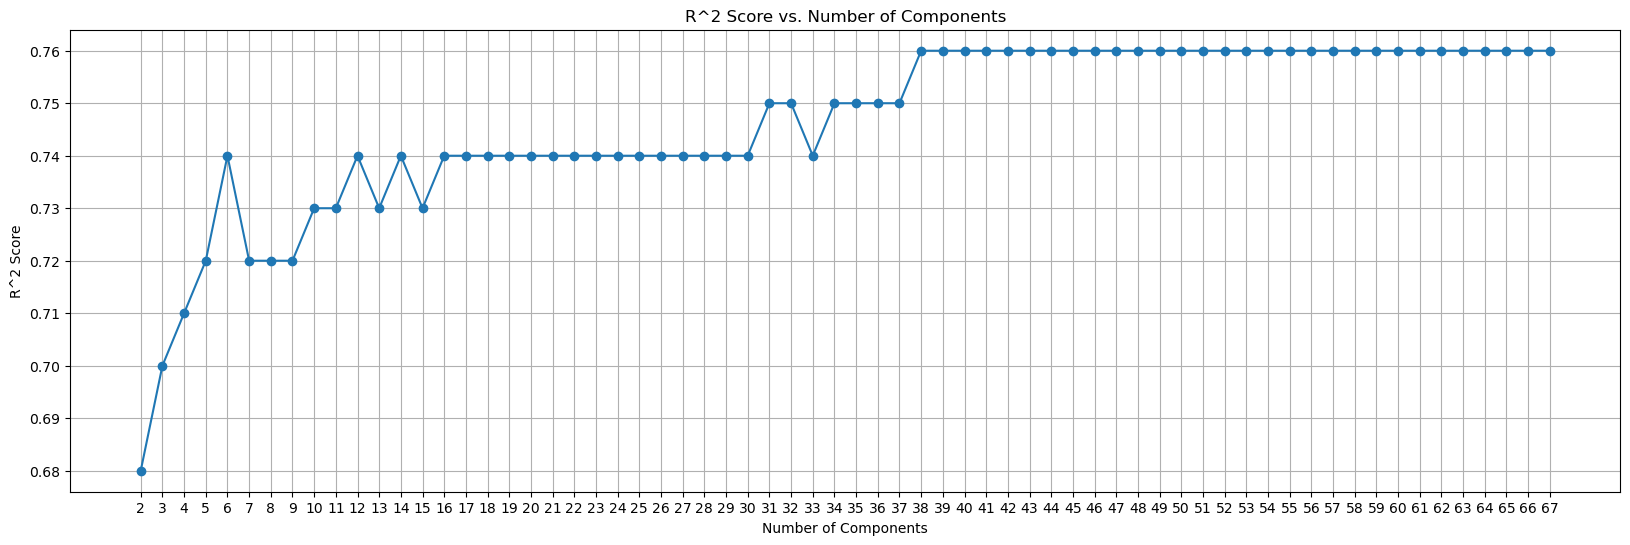

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(comp_range, r2s, marker='o')
plt.title('R^2 Score vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.xticks(comp_range)
plt.show()

Based on the analysis, the optimal number of components is 40

In [49]:
# Running PCA to limit the dataset to 40 features
opt_n = 40
X_train_pca, X_val_pca, X_test_pca = apply_pca(opt_n, X_train, X_val, X_test)

#### Optimizing the decision tree by tuning the hyperparameters
Running the algorithm over and over until the exact optimal values are reached

In [60]:
opt_r2 = 0
opt_params = None

parameters = {
    'max_depth_': [19, 20, 21, None],
    'min_samples_split_': [44, 45, 46],
    'min_samples_leaf_': [13, 14, 15]
}

# looping through the potential parameters
for d in parameters['max_depth_']:
    for s in parameters['min_samples_split_']:
        for l in parameters['min_samples_leaf_']:
            model5 = DecisionTreeRegressor(max_depth=d, min_samples_split=s, min_samples_leaf=l)
            model5.fit(X_train_pca, y_train)
            y_val_pred5 = model5.predict(X_val_pca)
            ss_res = np.sum((y_val - y_val_pred5) ** 2)
            ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            # if new optimal r^2 is found, replace the r^2
            if r2 > opt_r2:
                opt_r2 = r2
                opt_params = {'max_depth': d, 'min_samples_split': s, 'min_samples_leaf': l}

print('Optimal Parameters:', opt_params)

# training a new model with optimal params
model5 = DecisionTreeRegressor(**opt_params)
model5.fit(X_train_pca, y_train)

# evaluating the model on the validation set
y_val_pred5 = model5.predict(X_val_pca)
print('\nValidation set results:')
get_estimates(y_val, y_val_pred5)

# evaluating the model on the test set
y_test_pred5 = model5.predict(X_test_pca)
print('\nTest set results:')
get_estimates(y_test, y_test_pred5)

Optimal Parameters: {'max_depth': 20, 'min_samples_split': 45, 'min_samples_leaf': 14}

Validation set results:
Root Mean Squared Error (RMSE): 2667
Mean Absolute Error (MAE):      1580
Median Absolute Error (MedAE):   826
R^2 Score:                      0.78

Test set results:
Root Mean Squared Error (RMSE): 2706
Mean Absolute Error (MAE):      1590
Median Absolute Error (MedAE):   825
R^2 Score:                      0.78


Comparing the final results with the results of the baseline Decision Tree Regressor:

In [61]:
print('\nValidation set results for baseline Decision Tree:')
get_estimates(y_val, y_val_pred3)


Validation set results for baseline Decision Tree:
Root Mean Squared Error (RMSE): 2730
Mean Absolute Error (MAE):      1535
Median Absolute Error (MedAE):   771
R^2 Score:                      0.77
